In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
from fastai.text.all import *
from pathlib import Path
import numpy as np
import pandas as pd
import sys 
from time import sleep

In [2]:
DATA_PATH = Path("/data/wr153")

pretrained_weights = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights, add_prefix_space=True)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

df_train = pd.read_csv(DATA_PATH.joinpath("text", "train.csv"), header=0)
df_valid = pd.read_csv(DATA_PATH.joinpath("text", "test.csv"), header=0)

all_texts = np.concatenate([df_train.to_numpy(), df_valid.to_numpy()], axis=0)


class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encodes(self, x):
        toks = self.tokenizer.tokenize(x, is_split_into_words=True)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))

    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(
    all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader
)

bs, sl = 4, 512
dls = tls.dataloaders(bs=bs, seq_len=sl)


class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]


In [3]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [4]:
learn.freeze()

SuggestedLRs(valley=0.00015848931798245758)

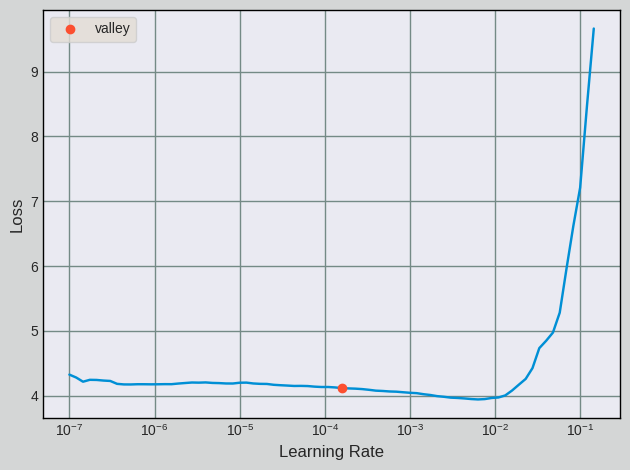

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.017654,3.767206,43.259048,00:07
1,3.809860,3.706823,40.724205,00:07
2,3.649802,3.699677,40.434250,00:07


In [49]:
prompt = "The revolution in Iran"

In [50]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()

In [51]:
# https://huggingface.co/blog/how-to-generate
preds = learn.model.generate(
    inp,
    do_sample=True,
    max_length=100,
    top_k=50, 
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
    temperature=1.0,
)
words = tokenizer.decode(preds[0].cpu().numpy())
words

" The revolution in Iran is now over. In our country, the revolution doesn't always happen in a straight line. in my country, it's often seen as a battle between two groups. in this case, they have two sides. the leaders of both are on the same side, since the revolution didn't start out as a peaceful revolution in the streets. so, it's not all bad, it's just that the revolution wasn't peaceful in all the places. the next day my grandma came"

In [70]:
print(f"Input prompt: {prompt}", end="\n\n")

print("-----------------------AI Generated Sentence-Completion----------------------", end="\n\n")
for char in words:
    sleep(0.025)
    sys.stdout.write(char)
    sys.stdout.flush()

Input prompt: The revolution in Iran

-----------------------AI Generated Sentence-Completion----------------------

 The revolution in Iran is now over. In our country, the revolution doesn't always happen in a straight line. in my country, it's often seen as a battle between two groups. in this case, they have two sides. the leaders of both are on the same side, since the revolution didn't start out as a peaceful revolution in the streets. so, it's not all bad, it's just that the revolution wasn't peaceful in all the places. the next day my grandma came

In [10]:
torch.save(learn.state_dict(), "models/gpt2.pt")

In [11]:
learn.load_state_dict(torch.load("models/gpt2.pt"))
learn.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)